# The Reuters corpus

### Importing all the libraries

In [1]:
import os
import glob
import nltk
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
import plotly.express as px

# Suppress all warnings
warnings.filterwarnings("ignore")

### Defining stopwords and punctutations

In [2]:
import nltk
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

# Stopwords set and punctuation set
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vgupt\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vgupt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Storing all the texts of the author in a dictionary and pre-processing the text

In [3]:
# Path to the folder containing author subfolders
c50_train_dir = "ReutersC50/C50train"

# Load and preprocess text data
author_texts = {}  # Dictionary to store texts written by each author

for author_subdir in os.listdir(c50_train_dir):
    author_dir = os.path.join(c50_train_dir, author_subdir)
    if os.path.isdir(author_dir):
        author_text = ''
        for text_file in glob.glob(os.path.join(author_dir, '*.txt')):
            with open(text_file, 'r', encoding='utf-8') as f:
                text = f.read()
                author_text += ' ' + text
        author_texts[author_subdir] = author_text

        
# Text preprocessing
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in punctuations and word not in stop_words]
    return ' '.join(tokens)

preprocessed_author_texts = {author: preprocess_text(text) for author, text in author_texts.items()}

### Creating a TF-IDF matrix with 1000 words for each author

In [4]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(list(preprocessed_author_texts.values()))

In [37]:
tfidf_matrix

<50x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 38323 stored elements in Compressed Sparse Row format>

### Performing PCA and looking at cumulative variance explained by upto 50 components

In [5]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=50)  # Reduce to a reasonable number of components
reduced_features_pca = pca.fit_transform(tfidf_matrix.toarray())

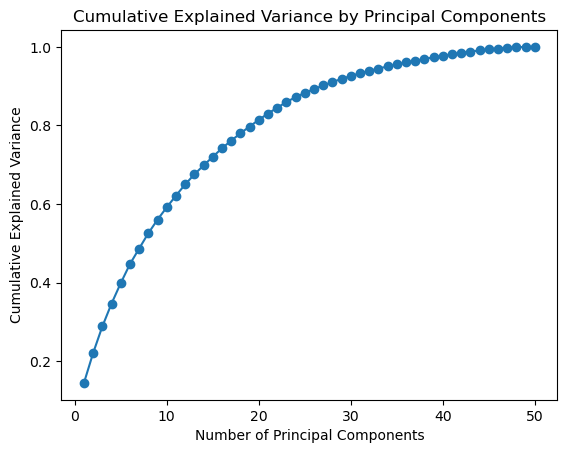

In [6]:
# Get explained variance ratios
explained_variance_ratios = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratios)

# Plot explained variance ratios
plt.plot(range(1, 51), cumulative_explained_variance, marker='o')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

We can see that almost all variance of the data is explained by 50 components of PCA

### Performing t-SNE on the reduced features

In [82]:
# Perform t-SNE on reduced PCA features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=1)
reduced_features_tsne = tsne.fit_transform(reduced_features_pca)

### Performing clustering on 2-D t-SNE components

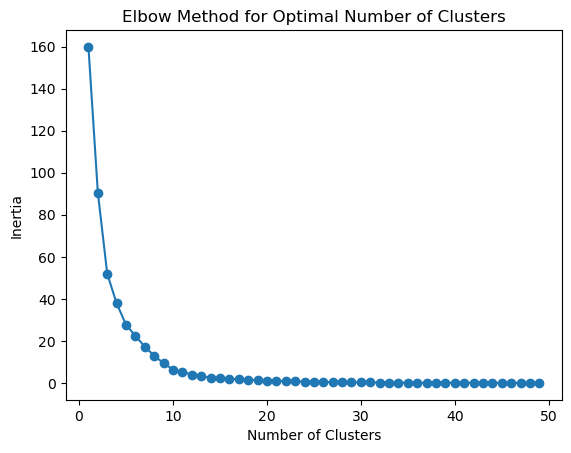

In [87]:
# Calculate the sum of squared distances (inertia) for different number of clusters
inertia_values = []
for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features_tsne)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 50), inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Based on the above plot and the scatter plot below we selected k to be 11

In [83]:
# Apply K-Means clustering on t-SNE components
n_clusters = 11
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features_tsne)

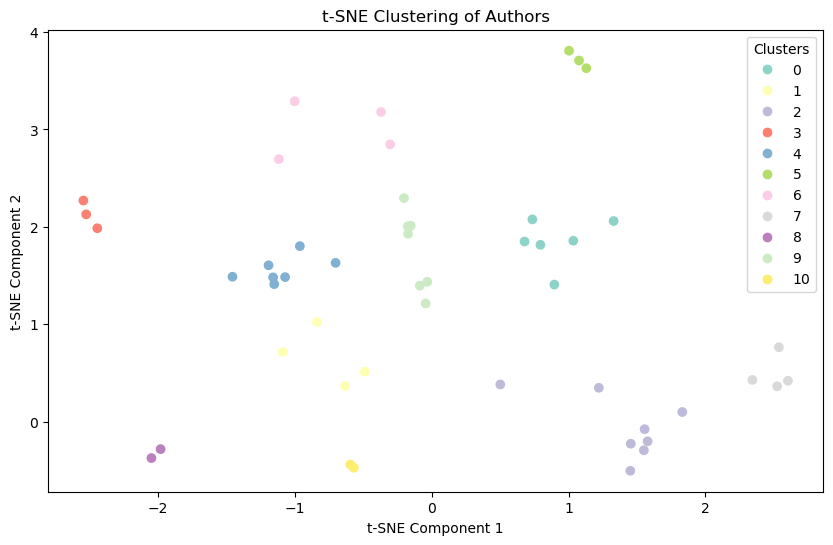

In [93]:
# Visualize the clusters in a scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_features_tsne[:, 0], reduced_features_tsne[:, 1], c=cluster_labels, cmap='Set3')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("t-SNE Clustering of Authors")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

We can now do some spot checks to see if there are some clear characteristics of the clusters

### Creating an interactive plot to see the names of authors in each of the clusters

In [99]:

# Create DataFrame for visualization
import pandas as pd


df = pd.DataFrame({
    'Author': list(preprocessed_author_texts.keys()),
    'X': reduced_features_tsne[:, 0],
    'Y': reduced_features_tsne[:, 1],
    'Cluster': cluster_labels
})

# Create an interactive scatter plot using plotly
fig = px.scatter(
    df, x='X', y='Y', color='Cluster', hover_name='Author',
    title='Author Clustering based on Texts', labels={'X': 't-SNE Component 1', 'Y': 't-SNE Component 2'},
    color_discrete_sequence=px.colors.qualitative.Plotly
)

fig.show()

### Let's see what is common between cluster 3 authors:

Heather Scoffield, Lydia Zajc & Darren Schutteler

Turns out, all 3 of them write on Canadian markets

### Let's test another cluster - 5:

Alan Crosby, John Mastrini and Jan Lopatka

Turns out, all 3 of them write about Czech Republic

### Identifying the most frequent words in each of the clusters

In [80]:
# Create a DataFrame combining cluster labels and TF-IDF features
cluster_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
cluster_df['Cluster'] = cluster_labels

In [81]:
# For each cluster, find the words with the highest mean TF-IDF values
top_words_per_cluster = {}
for cluster in range(n_clusters):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster].drop('Cluster', axis=1)
    top_words = cluster_data.mean().sort_values(ascending=False).head(20).index.tolist()
    top_words_per_cluster[cluster] = top_words

# Print the top words for each cluster
for cluster, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(top_words)}")

Cluster 0: said, internet, microsoft, software, the, computer, apple, new, company, online, quarter, year, ibm, percent, pc, analysts, would, windows, million, market
Cluster 1: said, mci, bt, the, pounds, would, percent, market, billion, million, company, yen, amp, year, new, british, japan, analysts, telecoms, at
Cluster 2: said, china, beijing, chinese, the, wang, would, fcc, hong, taiwan, shanghai, kong, tibet, year, foreign, yuan, officials, communist, percent, official
Cluster 3: toronto, said, gold, barrick, the, canadian, canada, bank, busang, million, indonesian, billion, percent, year, stock, shares, stocks, banks, index, analysts
Cluster 4: said, pounds, million, the, pence, percent, would, year, company, group, market, stg, british, billion, profits, pound, britain, business, new, one
Cluster 5: czech, klaus, said, prague, the, crowns, percent, senate, coalition, would, crown, elections, bank, year, market, billion, deficit, first, government, social
Cluster 6: said, cocoa,

This gives us an idea of what are some of the common terms used by authors in each of the clusters thus indicating how and why they have been clustered. For example - Cluster 7 are most likely to be authors who write on China and adjoining region while Cluster 10 authors most likely write about France